In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [55]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 5e-5  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 15
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 500
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.02

In [23]:
device

device(type='cuda')

In [24]:
transforms = transforms.Compose([
    transforms.Resize([64,64]),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for i in range(CHANNELS_IMG)], [0.5 for i in range(CHANNELS_IMG)])
])

In [25]:
IMAGE_PATH = 'C:/Users/Ray/OneDrive/Desktop/Capstone Project/GAN_images/Crests_Raw'
IMAGE_PATH

'C:/Users/Ray/OneDrive/Desktop/Capstone Project/GAN_images/Crests_Raw'

In [26]:
dataset = datasets.ImageFolder(IMAGE_PATH, transform = transforms)


In [27]:
def split_indices(n, val_per, seed = 0):
    n_val = int(n * val_per)
    np.random.seed(seed)
    idx = np.random.permutation(n)
    return idx[n_val : ], idx[: n_val]

In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
val_per = 0.4
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_per, rand_seed)

print(len(train_indices), len(val_indices))

824 549


In [30]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [31]:
# training data loader
train_sampler = SubsetRandomSampler(train_indices)
loader = DataLoader(dataset, BATCH_SIZE, sampler = train_sampler)

In [32]:
class Discriminator(nn.Module):
    
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            #size = 3*64*64
            nn.Conv2d(channels_img, features_d, kernel_size = 4, stride = 2, padding = 1), # Size : 32*32
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d, features_d*2, kernel_size = 4, stride = 2, padding = 1), # size = 16*16
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*2, features_d*4, kernel_size = 4, stride = 2, padding = 1), # size = 8*8
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*4, features_d*8, kernel_size = 4, stride = 2, padding = 1), # size = 4*4
            nn.BatchNorm2d(features_d*8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features_d*8, 1, kernel_size = 4, stride = 2, padding = 0) #1*1
            
        )
        
        
    def forward(self, x):
        return self.disc(x)

In [33]:
class Generator(nn.Module):
    
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g*16, kernel_size = 4, stride = 1, padding = 0), # size = 4*4
            nn.BatchNorm2d(features_g*16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*16, features_g*8, kernel_size = 4, stride = 2, padding = 1), # size = 8*8
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*8, features_g*4, kernel_size = 4, stride = 2, padding = 1), # size = 16*16
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*4, features_g*2, kernel_size = 4, stride = 2, padding = 1), # size = 32*32
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()  # [-1, 1]
        )
        
    
    def forward(self, x):
        return self.net(x)

In [34]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [37]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print('Success')

In [38]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(z_dim = NOISE_DIM, channels_img = CHANNELS_IMG, features_g = FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [39]:
opt_gen = optim.RMSprop(gen.parameters(), lr = LEARNING_RATE)
opt_disc = optim.RMSprop(disc.parameters(), lr = LEARNING_RATE)

In [40]:
def reset_grad():
    opt_disc.zero_grad()
    opt_gen.zero_grad()

In [41]:
def train_discriminator(images):
    # create labels, for real image label is 1, for fake 
    
    # loss for real images
    
    for _ in range(CRITIC_ITERATIONS):
        
        disc_real = disc(images).reshape(-1)
        #d_loss_real = torch.mean(disc_real)
        real_score = disc_real
        
        
        z = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake_images = gen(z)
        disc_fake = disc(fake_images).reshape(-1)
        #d_loss_fake = torch.mean(disc_fake)
        fake_score = disc_fake
        
        loss_disc = - (torch.mean(disc_real) - torch.mean(disc_fake))
        
        reset_grad()
        
        loss_disc.backward()
        
        opt_disc.step()
        
        for p in disc.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
        
        return loss_disc, real_score, fake_score 

In [42]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
    fake_images = gen(z)
    labels = torch.ones(BATCH_SIZE, 1).to(device)
    output = disc(fake_images).reshape(-1)
    g_loss = - torch.mean(output)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    opt_gen.step()
    return g_loss, fake_images

In [43]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [44]:
def show_img(img, label):
    print('Label: ', label)
    plt.imshow(img.permute(1,2,0), cmap = 'gray')

In [45]:
def denorm(x):
  out = (x + 1) / 2
  return out.clamp(0, 1)

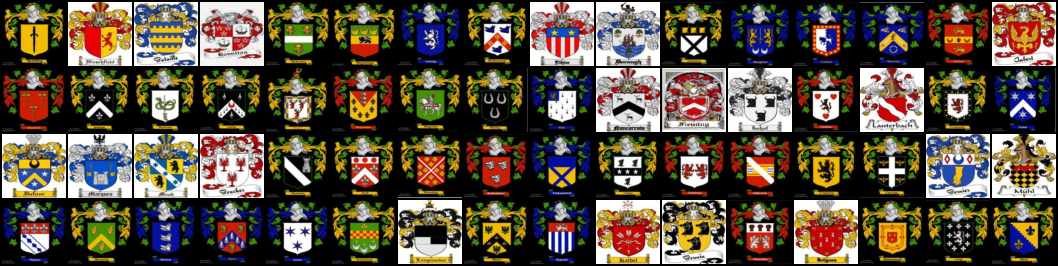

In [46]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in loader:
    images = images.reshape(images.size(0), 3, 64, 64)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=16)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


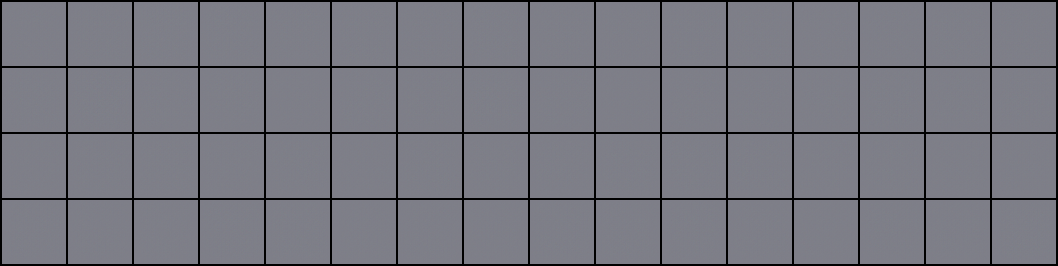

In [47]:
sample_vectors = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

def save_fake_images(index):
    fake_images = gen(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=16)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [56]:
%%time


total_step = len(loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(NUM_EPOCHS):
    for i, (images, _) in enumerate(loader):
        # Load a batch & transform to vectors
        images = images.to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) / 100 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Saving fake_images-0001.png
Saving fake_images-0002.png
Saving fake_images-0003.png
Saving fake_images-0004.png
Saving fake_images-0005.png
Saving fake_images-0006.png
Saving fake_images-0007.png
Saving fake_images-0008.png
Saving fake_images-0009.png
Saving fake_images-0010.png
Saving fake_images-0011.png
Saving fake_images-0012.png
Saving fake_images-0013.png
Saving fake_images-0014.png
Saving fake_images-0015.png
Saving fake_images-0016.png
Saving fake_images-0017.png
Saving fake_images-0018.png
Saving fake_images-0019.png
Saving fake_images-0020.png
Saving fake_images-0021.png
Saving fake_images-0022.png
Saving fake_images-0023.png
Saving fake_images-0024.png
Saving fake_images-0025.png
Saving fake_images-0026.png
Saving fake_images-0027.png
Saving fake_images-0028.png
Saving fake_images-0029.png
Saving fake_images-0030.png
Saving fake_images-0031.png
Saving fake_images-0032.png
Saving fake_images-0033.png
Saving fake_images-0034.png
Saving fake_images-0035.png
Saving fake_images-0

Saving fake_images-0294.png
Saving fake_images-0295.png
Saving fake_images-0296.png
Saving fake_images-0297.png
Saving fake_images-0298.png
Saving fake_images-0299.png
Saving fake_images-0300.png
Saving fake_images-0301.png
Saving fake_images-0302.png
Saving fake_images-0303.png
Saving fake_images-0304.png
Saving fake_images-0305.png
Saving fake_images-0306.png
Saving fake_images-0307.png
Saving fake_images-0308.png
Saving fake_images-0309.png
Saving fake_images-0310.png
Saving fake_images-0311.png
Saving fake_images-0312.png
Saving fake_images-0313.png
Saving fake_images-0314.png
Saving fake_images-0315.png
Saving fake_images-0316.png
Saving fake_images-0317.png
Saving fake_images-0318.png
Saving fake_images-0319.png
Saving fake_images-0320.png
Saving fake_images-0321.png
Saving fake_images-0322.png
Saving fake_images-0323.png
Saving fake_images-0324.png
Saving fake_images-0325.png
Saving fake_images-0326.png
Saving fake_images-0327.png
Saving fake_images-0328.png
Saving fake_images-0

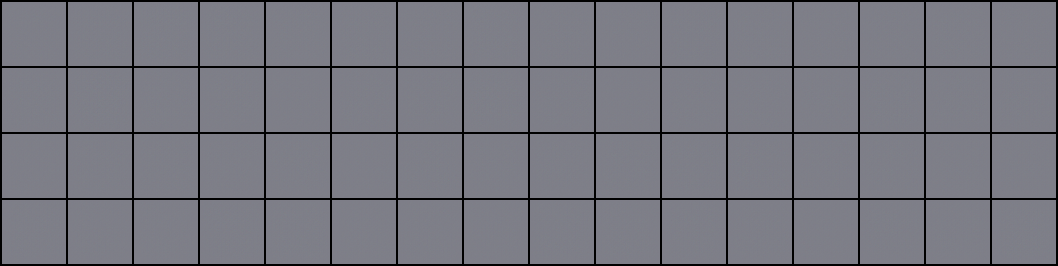

In [50]:
Image('./samples/fake_images-0000.png')


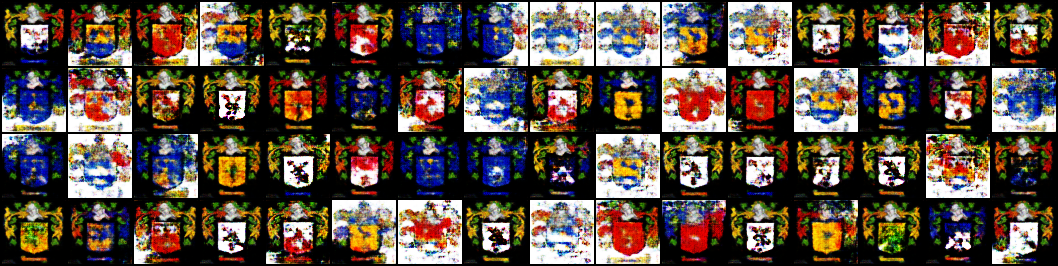

In [59]:
Image('./samples/fake_images-0400.png')
